In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from flowdec.nb import utils as nbutils 
from flowdec import data as fd_data
import pims
# import pims
from flowdec import restoration as fd_restoration
from flowdec import data as fd_data
from flowdec import psf as fd_psf
import dask
import dask.array as da
import tifffile as tf
from nd2reader import ND2Reader
# from pims import ND2_Reader as ND2Reader
# import aicsimageio.vendor.omexml as ome

In [2]:
# channels = ['miRFP670', 'mRuby3','FITC']
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)



In [18]:
# fname = 'igfp1_caruby5_continue001trigger003.nd2'
datadir = '/media/Mamede/20200626/'
# fname1="LCB _647_CL25_DAPI_Cu001.nd2"
# fname1 = "igfp1_caruby5_continue001trigger003.nd2"
fname1 = "igfp1_caruby5_continue001trigger004.nd2"
# fname1="LCB _647_CL25_DAPI_AU003.nd2"
fname = datadir+fname1
# fname = '/tmp/test.ome.tiff'

frames =  ND2Reader(fname)
frames.iter_axes = 't'  # 't' is the default already
frames.bundle_axes = 'zyx'  # when 'z' is available, this will be default
# frames.iter_axes
xdivide = 2
ydivide = 2
zdivide = 1

/home/jmamede/anaconda3/lib/python3.7/site-packages/nd2reader/common_raw_metadata.py:99: RuntimeWarning: Reported average frame interval (1799912.2 ms) doesn't match the set interval (1800000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


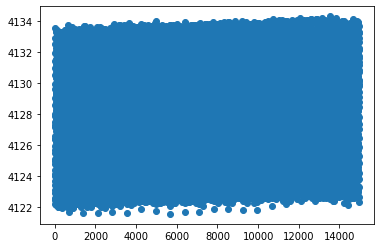

In [19]:
channels =  frames.metadata['channels']
metadata = frames.metadata
# print(metadata.keys())
plt.scatter(range(len(frames.metadata['z_coordinates'])),frames.metadata['z_coordinates'])

In [20]:
print(frames.sizes)

{'x': 2048, 'y': 2044, 'c': 3, 't': 21, 'z': 23, 'v': 31}


In [21]:
def Nd2meta2OMEXML(reader, project=False):
#     from apeer_ometiff_library import omexmlClass
    import aicsimageio.vendor.omexml as omexmlClass
    
    #Missing TODO:
    #<Image>,  Name = "ImageName"
    #Instrument ID and Detector ID and Objective 
#     frames.parser._raw_metadata.image_metadata[b'SLxExperiment'][b'wsCameraName']

    # Objective settings with Refractive Index
        #Pixels, 
            #Channel Color = RGB###, EmissionWavelength, Name of Channel.
            #Plane  ExposureTime, Position X, Y, Z (Z is easy as it's in nd2reader metadata)
    def writeplanes(pixel, SizeT=1, SizeZ=1, SizeC=1, order='TZCYX', verbose=False):

        if order == 'TZCYX':

            pixel.DimensionOrder = omexmlClass.DO_XYCZT
            counter = 0
            for t in range(SizeT):
                for z in range(SizeZ):
                    for c in range(SizeC):

                        if verbose:
                            print('Write PlaneTable: ', t, z, c),
                            sys.stdout.flush()

                        pixel.Plane(counter).TheT = t
                        pixel.Plane(counter).TheZ = z
                        pixel.Plane(counter).TheC = c
                        #check basically because of triggered acquisition the arrays shouldn't have the size of "channel"
                        pixel.Plane(counter).DeltaT = reader.get_timesteps()[counter//SizeC]
                        pixel.Plane(counter).PositionZ = nd2meta['z_coordinates'][counter//SizeC]
#                         pixel.Plane(counter).ExposureTime = 
#                         pixel.Plane(counter).PositionX =
#                         pixel.Plane(counter).PositionY = 
#                         pixel.Plane(counter).
                        counter = counter + 1
                        
    
        return pixel
    
    #make a metadata var
    nd2meta = reader.metadata

#     Series = nd2meta['fields_of_view'][-1]+1
    scalex = nd2meta['pixel_microns']
    scaley = scalex
    if not project:
#         scalez = round(nd2meta['z_coordinates'][1]-nd2meta['z_coordinates'][0],3)
#         scalez = frames.parser._raw_metadata.image_metadata[b'SLxExperiment'][b'ppNextLevelEx'][b''][b'ppNextLevelEx'][b''][b'uLoopPars'][b'dZStep']
        scalez = 0.5
    pixeltype = 'uint16'
    dimorder = 'TZCYX'
# print(a)
    omexml = omexmlClass.OMEXML()
#     omexml.image_count = 1
#     omexml.image_count = reader.sizes['v']
    #Try to find if PIMS outputs the filename somehow.
    omexml.image(0).Name = 'Mamede Lab Image'
#     for i in range(frames.sizes['t']):
    p = omexml.image(0).Pixels
    p.SizeX = frames.sizes['x']
    p.SizeY = frames.sizes['y']
    p.SizeC = frames.sizes['c']
    p.SizeT = frames.sizes['t']
    if project:
        p.SizeZ = 1
    else:
        p.SizeZ = frames.sizes['z']
        
    p.PhysicalSizeX = np.float(scalex)
    p.PhysicalSizeY = np.float(scaley)
    if not project:
        p.PhysicalSizeZ = np.float(scalez)
    p.PixelType = pixeltype
    p.channel_count = frames.sizes['c']
    
    if project:
        p.plane_count = 1 * p.SizeT * p.SizeC #* SizeV
    else:
        p.plane_count = p.SizeZ * p.SizeT * p.SizeC #* SizeV


    #I am using separate files for each visit point
    #, if you want one tiff with all visit points (possibly good for panels) 
    #you will need to update this section
    
    if project:
        p = writeplanes(p, SizeT=p.SizeT, SizeZ=1, SizeC=p.SizeC, order=dimorder)
    else:
        p = writeplanes(p, SizeT=p.SizeT, SizeZ=p.SizeZ, SizeC=p.SizeC, order=dimorder)
    for c in range(p.SizeC):
        p.Channel(c).Name = nd2meta['channels'][c]
#         p.Channel(c).Color =
#         p.Channel(c).EmissionWavelength =
        if pixeltype == 'unit8':
            p.Channel(c).SamplesPerPixel = 1
        if pixeltype == 'unit16':
            p.Channel(c).SamplesPerPixel = 2
            
    p.populate_TiffData()
#     omexml.structured_annotations.add_original_metadata(omexmlClass.OM_SAMPLES_PER_PIXEL, str(p.SizeC))

    return omexml


In [22]:
# nd2meta = metadata
xml = Nd2meta2OMEXML(frames)
prjxml = Nd2meta2OMEXML(frames, project=True)
# xml.image().Pixels.PhysicalSizeZ
# print(beta)
# frames
# print(xml)
# import aicsimageio.vendor.omexml as omexmlClass
# omexml = omexmlClass.OMEXML()
# p = omexml.image(0).Pixels
# p.populate_TiffData()

# ome = omexml.to_xml().encode()
# print(ome)

In [23]:
# xml.to_xml()

In [24]:
psf =[]
#psf = fd_psf.GibsonLanni.load('/tmp/psf.json')

# args = [na=1.4, wavelength= 0.594 , size_z=  11, size_x=  2048, size_y=  2044,
#         m :60,ns =  1.333, ni =  1.5156, tg =  170,         
#         res_lateral =  0.108333333333333, res_axial =  0.3, pZ = 1]

# args = [{"na": 1.4, "wavelength": '0.594' ,
#          "size_z": 11, "size_x": 2048, "size_y": 2044,
#          "m" :60,"ns" : 1.333, "ni" : 1.5156, "tg" : 170,
#          "res_lateral" : 0.108333333333333, "res_axial" : 0.3,
#          "pZ" :1}]

#na = meta['NA']
na = 1.4
#ra = meta['refractive_index1']
ra = 1.5156
z = frames.sizes['z'] // zdivide
# z = 30
# x = frames.sizes['x'] // xdivide
# y = frames.sizes['y'] // ydivide
x = 512
y = 512
res_z = xml.image().Pixels.PhysicalSizeZ
res_xy =  xml.image().Pixels.PhysicalSizeX

##Make better with automatic wavelength from metadata and a loop and a dictionary with the PSFs
psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.670 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra
    ,res_lateral =  res_xy , res_axial = res_z, 
    #pz = 1
)
psf647 = psf.generate()    
    
psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.620 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra
    ,res_lateral =  res_xy , res_axial = res_z, 
    #pz = 1
)
psfruby = psf.generate()

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.535 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra
    ,res_lateral =  res_xy , res_axial = res_z, 
    #pz = 1
)
psfgfp = psf.generate()

psf = fd_psf.GibsonLanni(
    na = na, wavelength= 0.420 , size_z=  z, size_x=  x , size_y=  y
    ,m =60, ns =  1.333
    , tg =  170, tg0 = 170
    , ni0 =  ra, ni =  ra
    ,res_lateral =  res_xy , res_axial = res_z, 
    #pz = 1
)
psfdapi = psf.generate()  
psf = psfgfp
def observer(img, i, *args):
    #mgs.append(img.max(axis=0))
    if i % 5 == 0:
        print('Observing iteration = {} (dtype = {}, max = {:.3f})'.format(i, img.dtype, img.max())) 
        


# padding = (2,0,0)
# padding = np.ones(psfgfp.ndim)


#config = tf.ConfigProto(device_count={'GPU': 1})
#algo = fd_restoration.RichardsonLucyDeconvolver(n_dims=acq.data.ndim, pad_min=[1, 1, 1], session_config=config).initialize()
algo = fd_restoration.RichardsonLucyDeconvolver(n_dims=psfgfp.ndim
                                                , pad_mode='2357'
#                                                 , pad_mode='none'
#                                                 ,pad_min=(0,0,0)
#                                                 ,observer_fn=observer
                                                #,real_domain_fft=True
                                                #,device='/cpu:0'
                                               ).initialize()

print("Done")

Done


In [25]:
def deconv(chunk):
    # note that algo and cropped_kernel are from global scope ... ugly
#     print("chunk shape", chunk.shape)
    tmp = algo.initialize().run(fd_data.Acquisition(data=chunk, kernel=psf)
#                                 , session_config=tflow.compat.v1.ConfigProto(
#                                 device_count={'GPU': 1}        
#                                 , GPUOptions={'allow_growth' : 4}
#                                         )
                                ,niter=20
                               )
    return tmp.data

In [26]:
print((frames.sizes['z'],frames.sizes['y']//2,frames.sizes['x']//2))

(23, 1022, 1024)


In [ ]:
# cchunk_size=(frames.sizes['z'],1022,1024)
chunk_size=(frames.sizes['z'] // zdivide,frames.sizes['y'] // ydivide,frames.sizes['x'] // xdivide)
# chunk_size=(7,frames.sizes['y'],frames.sizes['x'])

# frames.iter_axes = 'v'
# for frame in frames:
for visit in range(frames.sizes['v']):
    #%timeit
    frames.default_coords['v'] = visit
    with tf.TiffWriter("/home/jmamede/Data/test/"
                       +fname1[:-4]
#                        +'SQTSOME_647_CL25_DAPI_Cugrids002_'
                       +str(visit)+'.ome.tiff'
                , bigtiff=True
                , imagej=False
                      ) as tif:
        with tf.TiffWriter("/home/jmamede/Data/test/"
                       +fname1[:-4]
#                        +'SQTSOME_647_CL25_DAPI_Cugrids002_'
                           +str(visit)+'PRJ.ome.tiff'
                , bigtiff=True
                , imagej=False
                      ) as tifprj:
            first = True
#             print('Visit:',visit)
            for time in range(frames.sizes['t']):
#                 print('Time:',time)
                res = np.zeros(
                    (frames.sizes['z'],frames.sizes['c'],frames.sizes['y'],frames.sizes['x'])
                    , dtype=np.float32)
                for i in range(frames.sizes['c']):
                    frames.default_coords['c'] = i
#                     print('Channel:',metadata['channels'][i])
                    ch = metadata['channels'][i]
                    if ch == '405 nm':
                        psf = psfdapi
                    elif ch == '555 nm':
                        psf = psfruby
                    elif ch == '470 nm':
                        psf = psfgfp

                    arr = da.from_array(frames[time]
    #                                     [:,0:2044,0:2044]
    #                                     [:,:,:]              
                                        , chunks=chunk_size)
#                     print(frames[time].shape,i, frames[i].max())

    #make mem efficient by creating and empty array with the right shape with all channels and then add it as it goes.
                    res[:,i,:,:] = arr.map_overlap(
    #                 res = arr.map_overlap(
                        deconv,depth=(0,32,32),
#                         deconv,depth=(0,0,0),
                        boundary='reflect',
                        dtype='float16').compute(num_workers=1)
    #                     res[i,:,:,:] = arr.map_blocks(
    #                         deconv,dtype='float32').compute(num_workers=1)
    
    
    # If we need to swap Channel and Z in the future
    #             img5d = np.swapaxes(img5d,0,1)
    
                    update_progress( (visit+1) * (time+1) / (frames.sizes['v']* frames.sizes['t']) )
                    print("Visit Point: {}/{} \t Time:{}/{} \t Channel:{}/{}".format(
                            visit+1, frames.sizes['v']
                            ,time+1, frames.sizes['t']
                            , i+1, frames.sizes['c']))

                if first:
                    tif.save(res.astype(np.uint16)
                        , compress=6
                        , description = xml.to_xml()
                        , photometric='minisblack'
                        #, datetime= True
                        , metadata= None
                        , contiguous=False
                        )
                    tifprj.save(res.astype(np.uint16).max(axis=0)
                        , compress=6
                        , description = prjxml.to_xml()
                        , photometric='minisblack'
                        #, datetime= True
                        , metadata= None
                        , contiguous=False
                        )
                    first = False
                else:
                    tif.save(res.astype(np.uint16)
                        , compress=6
#                         , description = xml.to_xml()
                        , photometric='minisblack'
                        , metadata= None
                        , contiguous=False
                        )
                    tifprj.save(res.astype(np.uint16).max(axis=0)
                        , compress=6
#                         , description = xml.to_xml()
                        , photometric='minisblack'
                        #, datetime= True
                        , metadata= None
                        , contiguous=False
                        )

        tif.close()
        tifprj.close()
        
update_progress(1)

print("Done")

Progress: [##------------------] 7.8%
Visit Point: 3/31 	 Time:17/21 	 Channel:3/3


In [ ]:
print("Done")